# Import the source data
The data is provided as a directory that is three levels deep (the third level is ommited in the following listing).
``` bash
fiete@ubu:~/Documents/studium/analyse_semi_und_unstrukturierter_daten$ tree -d -L 1 CAPTUM
CAPTUM
├── Allergic Diseases
├── ANA
├── Angioedema
├── anti-FcεRI
├── Antihistamine
├── Anti-IgE
├── anti-TPO IgE ratio
├── ASST
├── Basophil
├── BAT
├── BHRA
├── CRP
├── Cyclosporine
├── D-Dimer
├── dsDNA
├── Duration
├── Eosinophil
├── IL-24
├── Omalizumab
├── Severity
├── Thyroglobulin
├── Total IgE
└── TPO
```

To work further with the source data, it is useful to have a list of file paths for the pdfs. The following creates a list of all pdf files in the `CAPTUM` source folder.

In [1]:
import io
import string
import re
import os

import hashlib
import pandas as pd


from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, udf

import spacy
import gensim
from tika import parser
from wordcloud import WordCloud
from sklearn.feature_extraction import text
import matplotlib.pyplot as plt



/Users/arturgergert/miniconda3/envs/env_Spark/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
path = './CAPTUM'

pdf_filepaths = []
for root, directories, files in os.walk(path, topdown=False):
	for name in files:
		if name[-4:] == '.pdf':
			pdf_filepaths.append(os.path.join(root, name))

pdf_filepaths[:5]

['./CAPTUM/Basophil/dsDNA/Frezzolini 2006.pdf',
 './CAPTUM/Basophil/dsDNA/Hatada 2013.pdf',
 './CAPTUM/Basophil/Antihistamine/Kolkhir 2020.pdf',
 './CAPTUM/Basophil/Antihistamine/Magen 2014.pdf',
 './CAPTUM/Basophil/Antihistamine/Grattan 2000.pdf']

## Check data for duplicate entries
We can identify duplicate pdfs by computing the checksum of each file and then counting the unique values. So let us define the checksum function `get_checksum()`:

In [3]:
# https://stackoverflow.com/questions/16874598/how-do-i-calculate-the-md5-checksum-of-a-file-in-python#16876405



def extract_filename(filepath: str) -> str:
    filename = os.path.basename(filepath).split('.')
    return filename[0]


def get_checksum(filepath: str) -> str:
    # Open,close, read file and calculate MD5 on its contents 
    with open(filepath, 'rb') as file_to_check:
        # read contents of the file
        data = file_to_check.read()    
        # pipe contents of the file through
        return hashlib.md5(data).hexdigest()

# check that it works
file_one, file_one_copy, file_two = "./pdf_1.pdf", "./pdf_1 copy.pdf", "./pdf_2.pdf"

assert get_checksum(file_one) == get_checksum(file_one_copy), "should be equal"
assert get_checksum(file_one) != get_checksum(file_two), "should not be equal"


Then we can create a pandas dataframe from the list of filepath's and also add a checksum column that is computed using our `get_checksum()` function.

In [4]:

df = pd.DataFrame(pdf_filepaths, columns = ['path'])
df['Name'] = df['path'].apply(extract_filename)
df['checksum'] = df['path'].apply(get_checksum)
df

,path,Name,checksum
0,./CAPTUM/Basophil/dsDNA/Frezzolini 2006.pdf,Frezzolini 2006,abf25f5d73330709b62f2fec5f8ce10e
1,./CAPTUM/Basophil/dsDNA/Hatada 2013.pdf,Hatada 2013,e75de24ff800af17bdbb2a15ed294148
2,./CAPTUM/Basophil/Antihistamine/Kolkhir 2020.pdf,Kolkhir 2020,15876d2b9fc853226540ac2721356bd5
3,./CAPTUM/Basophil/Antihistamine/Magen 2014.pdf,Magen 2014,25a64f5ad337901168413c0c065bcdf4
4,./CAPTUM/Basophil/Antihistamine/Grattan 2000.pdf,Grattan 2000,3bb5dbb6aaa40c6d967d7efdef989cda
...,...,...,...
1042,./CAPTUM/Duration/Angioedema/Khakoo 2008.pdf,Khakoo 2008,1c634aaf9f1761af8aa3b6ce3af909f0
1043,./CAPTUM/Duration/Angioedema/Kolkhir 2017.pdf,Kolkhir 2017,85f369e6a4efa59a0a12926fa46a4b6b
1044,./CAPTUM/Duration/Angioedema/Choi 2018.pdf,Choi 2018,6763e63beea42a25526003399393ecab
1045,./CAPTUM/anti-TPO IgE ratio/Total IgE/Demirka...,Demirkan 2019,6122945821fc32ba5836f3ce6658666e


In the final step, we can analyse the results of this activity. It seems that our available data is in reality only half as large as it initially appears.

In [5]:
print('Total number of pdfs: {}'.format(df['checksum'].count()))
print('Total number of unique pdfs: {}'.format(len(df['checksum'].unique())))
df['checksum']


Total number of pdfs: 1047
Total number of unique pdfs: 464


0       abf25f5d73330709b62f2fec5f8ce10e
1       e75de24ff800af17bdbb2a15ed294148
2       15876d2b9fc853226540ac2721356bd5
3       25a64f5ad337901168413c0c065bcdf4
4       3bb5dbb6aaa40c6d967d7efdef989cda
                      ...               
1042    1c634aaf9f1761af8aa3b6ce3af909f0
1043    85f369e6a4efa59a0a12926fa46a4b6b
1044    6763e63beea42a25526003399393ecab
1045    6122945821fc32ba5836f3ce6658666e
1046    f13be81ffbff55e031a34ef81d43cbff
Name: checksum, Length: 1047, dtype: object

Now we create a df of unique pdfs by removing duplicate checksums

In [6]:
df_unique = df.drop_duplicates(subset=['checksum'])
df_unique.head()

,path,Name,checksum
0,./CAPTUM/Basophil/dsDNA/Frezzolini 2006.pdf,Frezzolini 2006,abf25f5d73330709b62f2fec5f8ce10e
1,./CAPTUM/Basophil/dsDNA/Hatada 2013.pdf,Hatada 2013,e75de24ff800af17bdbb2a15ed294148
2,./CAPTUM/Basophil/Antihistamine/Kolkhir 2020.pdf,Kolkhir 2020,15876d2b9fc853226540ac2721356bd5
3,./CAPTUM/Basophil/Antihistamine/Magen 2014.pdf,Magen 2014,25a64f5ad337901168413c0c065bcdf4
4,./CAPTUM/Basophil/Antihistamine/Grattan 2000.pdf,Grattan 2000,3bb5dbb6aaa40c6d967d7efdef989cda


In [7]:
#Create SparkSession

spark = SparkSession \
    .builder \
    .appName("Uticaria_Spark") \
    .getOrCreate()

In [8]:
urticaria_urls_rows = df_unique.loc[:,['Name','path']].values.tolist()

['Frezzolini 2006', './CAPTUM/Basophil/dsDNA/Frezzolini 2006.pdf']

In [9]:
# create a Pandas dataframe of Urticaria articles incl. path
urticaria_path_pd = pd.DataFrame(urticaria_urls_rows, columns=['article', 'path'])

# distribute the collection across the cluster to...
# ...exploit parallelism when downloading / curating information
urticaria_urls = spark.createDataFrame(urticaria_path_pd).repartition(8)


In [10]:
@udf('string')
def extract_content(path: str) ->str:
    try:
        
        raw = parser.from_file(path)
        return raw['content']
    except:
        return ""

@udf('string')
def extract_meta(path: str) ->str:
    try:
        
        raw = parser.from_file(path)
        return raw['metadata']
    except:
        return ""

# cache PDFs
urticaria_articles = urticaria_urls \
  .withColumn('content', extract_content(F.col('path'))) \
  .withColumn('meta', extract_meta(F.col('path'))) \
  .filter(F.length(F.col('content')) > 0) \
  .cache()

urticaria_articles.count()
urticaria_articles.show(1)




+--------+--------------------+--------------------+
| article|                path|             content|
+--------+--------------------+--------------------+
|Oda 2019|./CAPTUM/Basophil...|
















...|
+--------+--------------------+--------------------+
only showing top 1 row



In [11]:
def remove_non_ascii(text):
    printable = set(string.printable)
    return ''.join(filter(lambda x: x in printable, text))

def not_header(line):
    # as we're consolidating broken lines into paragraphs, 
    # we want to make sure not to include headers
    return not line.isupper()

def extract_statements(nlp, text):
  
    """
  Extracting desease statements from raw text by removing junk, URLs, etc.
  We group consecutive lines into paragraphs and use spacy to parse sentences.
    """
  
  # remove non ASCII characters
  
    text = remove_non_ascii(text)
  
    lines = []
    prev = ""
    for line in text.split('\n'):
    # aggregate consecutive lines where text may be broken down
    # only if next line starts with a space or previous does not end with dot.
        if(line.startswith(' ') or not prev.endswith('.')):
            prev = prev + ' ' + line
        else:
            # new paragraph
            lines.append(prev)
            prev = line
        
  # don't forget left-over paragraph
    lines.append(prev)

    # clean paragraphs from extra space, unwanted characters, urls, etc.
    # best effort clean up, consider a more versatile cleaner
    sentences = []
    for line in lines:

      # removing header number
      line = re.sub(r'^\s?\d+(.*)$', r'\1', line)
      # removing trailing spaces
      line = line.strip()
      # words may be split between lines, ensure we link them back together
      line = re.sub('\s?-\s?', '-', line)
      # remove space prior to punctuation
      line = re.sub(r'\s?([,:;\.])', r'\1', line)
      # remove figures that are not relevant to grammatical structure
      line = re.sub(r'\d{5,}', r' ', line)
      # remove mentions of URLs
      line = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', r' ', line)
      # remove multiple spaces
      line = re.sub('\s+', ' ', line)

      # split paragraphs into well defined sentences using spacy
      for part in list(nlp(line).sents):
        sentences.append(str(part).strip())

    return sentences

@pandas_udf('array<string>', PandasUDFType.SCALAR_ITER)
def extract_statements_udf(content_series_iter):
    """
    as loading a spacy model takes time, we certainly do not want to load model for each record to process
    we load model only once and apply it to each batch of content this executor is responsible for
    """

    # load spacy model
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm", disable=['ner'])

    # cleanse and tokenize a batch of PDF content 
    for content_series in content_series_iter:
        yield content_series.map(lambda x: extract_statements(nlp, x))

# *****************************
# apply transformation at scale
# *****************************

urticaria_statements = urticaria_articles \
  .withColumn('statements', extract_statements_udf(F.col('content'))) \
  .withColumn('statement', F.explode(F.col('statements'))) \
  .filter(F.length(F.col('statement')) > 100) \
  .select('article', 'statement') \
  .cache()

urticaria_statements.count()
display(urticaria_statements)

/Users/arturgergert/miniconda3/envs/env_Spark/lib/python3.6/site-packages/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


DataFrame[article: string, statement: string]

In [12]:
def tokenize(sentence):
    gen = gensim.utils.simple_preprocess(sentence, deacc=True)
    return ' '.join(gen)

def lemmatize(nlp, text):
  
    # parse sentence using spacy
    doc = nlp(text) 

    # convert words into their simplest form (singular, present form, etc.)
    lemma = []
    for token in doc:
        if (token.lemma_ not in ['-PRON-']):
            lemma.append(token.lemma_)

    return tokenize(' '.join(lemma))

@pandas_udf('string', PandasUDFType.SCALAR_ITER)
def lemma(content_series_iter):
    """
    as loading a spacy model takes time, we certainly do not want to load model for each record to process
    we load model only once and apply it to each batch of content this executor is responsible for
    """

    # load spacy model
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm", disable=['ner'])

    # lemmatize a batch of text content into sentences
    for content_series in content_series_iter:
        yield content_series.map(lambda x: lemmatize(nlp, x))
    
# *****************************
# apply transformation at scale
# *****************************

urticaria_lemma = urticaria_statements \
  .withColumn('lemma', lemma(F.col('statement'))) \
  .select('article', 'statement', 'lemma')

display(urticaria_lemma)

DataFrame[article: string, statement: string, lemma: string]

In [13]:
urticaria = urticaria_lemma.select("article", "statement", "lemma").toPandas()

In [14]:
# context specific keywords not to include in topic modelling
fsi_stop_words = [
  'sref', 'sbref', 'patient',
  'study', 'treatment', 'use',
]

# add Author names as stop words
for fsi in [row[0] for row in urticaria_urls_rows]:
    for t in fsi.split(' '):
        fsi_stop_words.append(t)

# our list contains all english stop words + article + specific keywords
stop_words = text.ENGLISH_STOP_WORDS.union(fsi_stop_words)


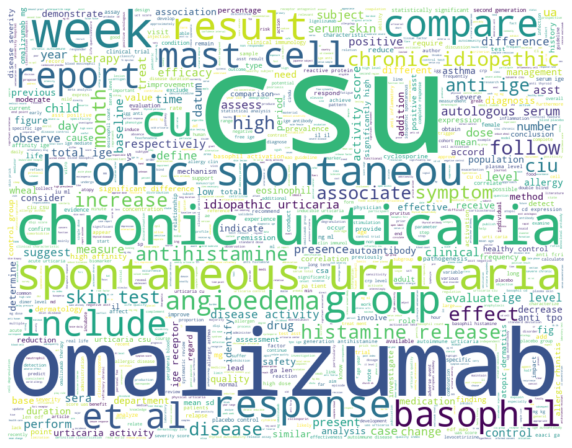

In [15]:


# aggregate all 7200 records into one large string to run wordcloud on term frequency
# we could leverage spark framework for TF analysis and call wordcloud.generate_from_frequencies instead
large_string = ' '.join(urticaria.lemma)

# use 3rd party lib to compute term freq., apply stop words
word_cloud = WordCloud(
    background_color="white",
    max_words=5000, 
    width=900, 
    height=700, 
    stopwords=stop_words, 
    contour_width=3, 
    contour_color='steelblue'
)

# display our wordcloud across all records
plt.figure(figsize=(10,10))
word_cloud.generate(large_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [17]:
urticaria[urticaria['article']=='Oda 2019'].to_csv('Oda_2019_testexport.csv', sep='#')